<a href="https://colab.research.google.com/github/iwmysihyhe/Travel-guide/blob/main/Cw2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import numpy as np
from scipy.sparse import coo_matrix

def wave(N):

    k = 29 * np.pi / 2
    h = 1 / N
    diagonal_value = 2 - h**2 * k**2
    off_diagonal_value = -1


    rows = []
    columns = []
    data = []


    f = np.zeros(N + 1, dtype=np.float64)
    f[N] = 1


    for i in range(N + 1):
        if i == 0:

            rows.append(i)
            columns.append(i)
            data.append(1)
        elif i == N:

            rows.append(i)
            columns.append(i)
            data.append(1)
        else:

            rows.append(i)
            columns.append(i)
            data.append(diagonal_value)

            rows.append(i)
            columns.append(i + 1)
            data.append(off_diagonal_value)

            rows.append(i)
            columns.append(i - 1)
            data.append(off_diagonal_value)


    row_ind = np.array(rows)
    col_ind = np.array(columns)
    data = np.array(data)


    return coo_matrix((data, (row_ind, col_ind)), shape=(N + 1, N + 1)).tocsr(), f


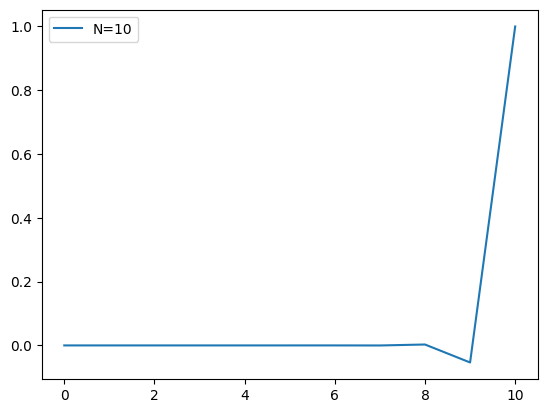

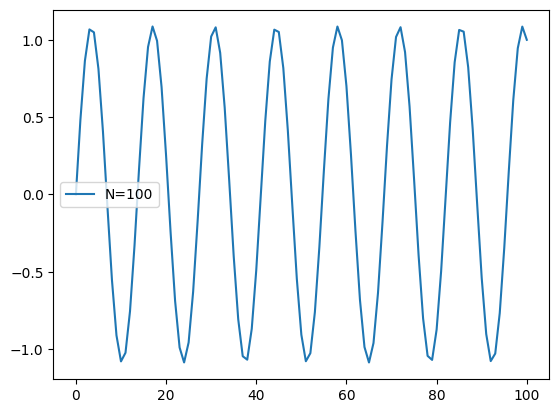

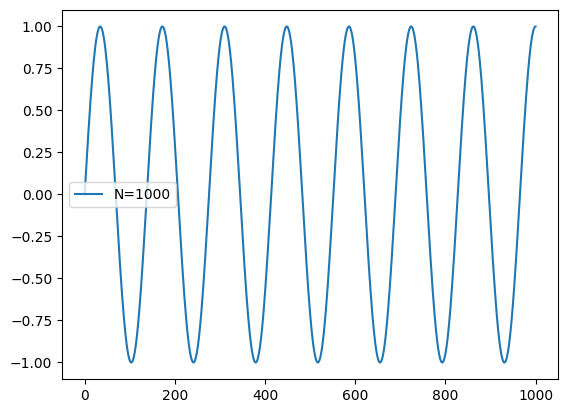

In [24]:
from scipy.sparse.linalg import spsolve
from matplotlib import pyplot as plt
%matplotlib inline
N = [10, 100, 1000]

for n in N:
  A, f = discretise_wave(n)
  u = spsolve(A, f)
  plt.plot(u,label=f'N={n}')
  plt.legend()
  plt.show()

Comment: When N is larger, the plot is more accurate.I expect N = 1000 to be closest to the actual solution of the wave problem.

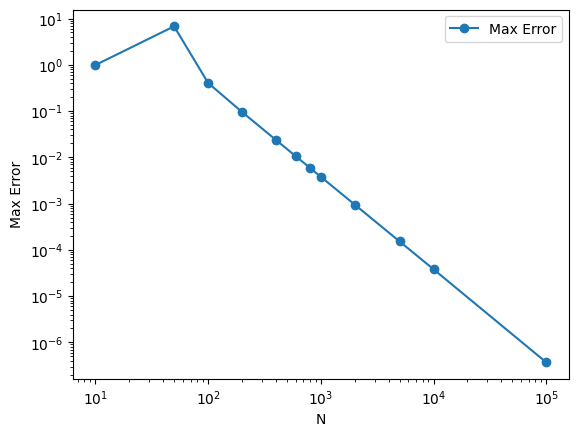

In [55]:
k = 29 * np.pi / 2
N_test = [10, 50, 100, 200, 400, 600, 800, 1000, 2000, 5000, 10000, 100000]
errors = []


for N in N_test:
    A, f = wave(N)
    u_app = spsolve(A, f)

    x = np.linspace(0, 1, N + 1)
    u_exact = np.sin(k * x)

    error = np.max(np.abs(u_app - u_exact))
    errors.append(error)

# Plotting N vs. Error on a log-log scale
plt.figure()
plt.loglog(N_test, errors, '-o', label='Max Error')
plt.xlabel('N')
plt.ylabel('Max Error')
plt.legend()
plt.show()

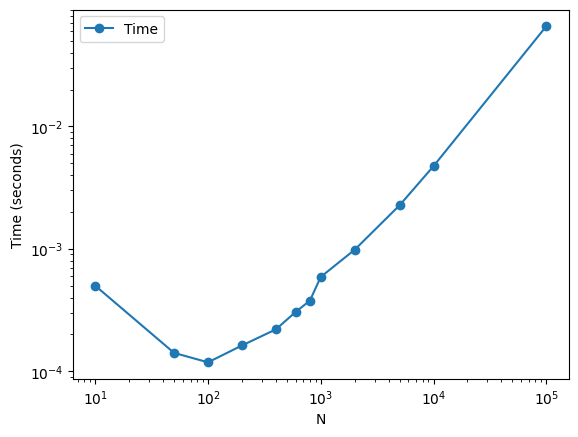

In [52]:
time_test = []

for N in N_test:

    A, f = wave(N)

    t = %timeit -o -q -n1 -r3 spsolve(A, f)

    time_test.append(t.average)

plt.figure()
plt.loglog(N_test, time_test, '-o', label='Time')
plt.xlabel('N')
plt.ylabel('Time (seconds)')
plt.legend()
plt.show()

Comment: I will pick N = 1000000 as the value that I expect the error would be 10^ -8 or less. I choose this value because when N = 100000 the max error is below 10 ^ -6. And the time I pridict is about 0.7s.

In [71]:
N_predict = 1000000
A, f = wave(N_predict)
u_1 = spsolve(A, f)

x = np.linspace(0, 1, N_predict + 1)
u_2 = np.sin(k * x)

error_predict = np.max(np.abs(u_1 - u_2))

t = %timeit -o -q -n1 -r3 spsolve(A, f)

print(f"Predicted Max Error: {error_predict}")
print(f"Predicted Time: {t.average}")

Predicted Max Error: 1.5517885523438912e-08
Predicted Time: 1.0215196106667765


Comment: The value of N is too large. So if we keep increasing the value of N,  calculations may become impractical, which can lead to running out of memory or taking too long.

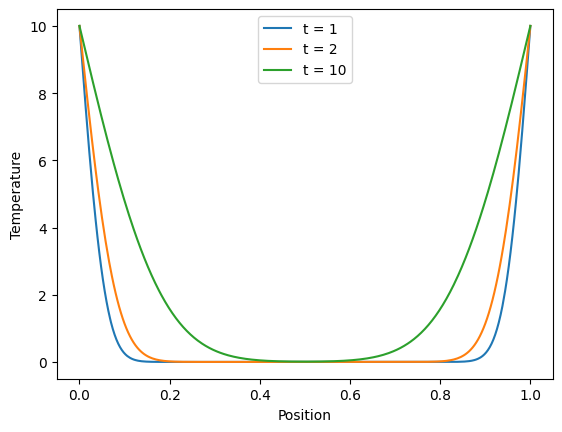

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def heat_equation(N, T):
    h = 1 / N
    coe = int(T / h)

    u = np.zeros(N + 1)
    u[0] = u[N] = 10

    for j in range(coe):
        u_new = u.copy()
        for i in range(1, N):
            u_new[i] = u[i] + (u[i-1] - 2 * u[i] + u[i+1]) / (1000 * h)
        u = u_new

    return u
%matplotlib inline
N = 500
times = [1, 2, 10]
for t in times:
    u = heat_equation(N, t)
    plt.plot(np.linspace(0, 1, N + 1), u, label=f't = {t}')
plt.xlabel("Position")
plt.ylabel("Temperature")
plt.legend()
plt.show()

Comment: When I picked a large value such as N = 1000, it is impossible for the polt to show. Considering that the value of N being small may cause large error, I chose N = 500.

In [4]:
import numba
from numba import cuda

@cuda.jit
def heat_equation_kernel(u, u_new, N, h):
    i = cuda.grid(1)
    if 0 < i < N:
        u_new[i] = u[i] + (u[i-1] - 2 * u[i] + u[i+1]) / (1000 * h)

def heat_equation_gpu(N, T):
    h = 1 / N
    coe = int(T / h)

    u_host = np.zeros(N + 1, dtype=np.float64)
    u_host[0] = u_host[N] = 10

    u_device = cuda.to_device(u_host)
    u_new_device = cuda.to_device(u_host)

    threads_per_block = 128
    blocks = (N + threads_per_block - 1) // threads_per_block

    for j in range(coe):
        heat_equation_kernel[blocks, threads_per_block](u_device, u_new_device, N, h)
        u_device, u_new_device = u_new_device, u_device

    u_device.copy_to_host(u_host)
    return u_host

In [6]:
def midpoint_temp(N, target_temp=9.8):
    h = 1 / N
    T_total = 0
    u_host = np.zeros(N + 1, dtype=np.float64)
    u_host[0] = u_host[N] = 10

    u_device = cuda.to_device(u_host)
    u_new_device = cuda.to_device(u_host)
    threads_per_block = 128
    blocks = (N + threads_per_block - 1) // threads_per_block

    midpoint_index = N // 2
    while True:
        heat_equation_kernel[blocks, threads_per_block](u_device, u_new_device, N, h)
        u_device, u_new_device = u_new_device, u_device
        u_device.copy_to_host(u_host)

        if u_host[midpoint_index] >= target_temp:
            break
        T_total += h

    return T_total

N = 500
time_to_9_8 = midpoint_temp(N, target_temp=9.8)
print(f"the time at which the temperature of the midpoint of the rod first exceeds a temperature of 9.8 is about{time_to_9_8} s。")

the time at which the temperature of the midpoint of the rod first exceeds a temperature of 9.8 is about420.84200000128135 s。


Comment: In this code, I first selected the value of N corresponding to the location of the center point. Then I iteratively calculated the temperature of the center point corresponding to each time interval h. Finally I compared the temperature with 9.8.